In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import cartopy
import cartopy.crs as ccrs


In [2]:
# Load grid 
ecco_grid = xr.open_dataset('/efs_ecco/ECCO/V4/r4/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid.load()

<xarray.Dataset> Size: 89MB
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 204B 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu       (k_u) float32 200B -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl       (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    XC_bnds  (tile, j, i, nb) float32 2MB -115.0 -115.0 -107.9 ... -115.0 -108.5
    YC_bnds  (tile, j, i, nb) float32 2MB -88.18 -88.32 -88.3 ... -88.18 -88.16
    Z_bnds   (k, nv) float32 400B 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 421kB 0.06158 0.06675 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 421kB -0.9981 -0.9978 ... -0.1705 -0.05718
    rA       (tile, j, i) float32 421kB 3.623e+08 3.633e+08 ... 3.611e+08
    dxG      (tile, j_g, i) float32 421kB 1.558e+04 1.559e+04 ... 2.314e+04
    dyG      (tile, j, i_g) float32 421kB 2.321e+04 2.327e+04 ... 1.558e+04
    Depth    (tile, j, i) float32 421kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...       ...
    hFacC    (k, tile, j, i) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW    (k, tile, j, i_g) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacS    (k, tile, j_g, i) float32 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskC    (k, tile, j, i) bool 5MB False False False ... False False False
    maskW    (k, tile, j, i_g) bool 5MB False False False ... False False False
    maskS    (k, tile, j_g, i) bool 5MB False False False ... False False False
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [3]:
# Get the model grid longitude and latitude
XC = ecco_grid.XC.values # modle grid longitude (13x90x90) 
YC = ecco_grid.YC.values # latitudes
# Also grid cell areaa in (m^2)
rA = ecco_grid.rA.values
maskC = ecco_grid.maskC.values # 3d mask (0/1) for model grid (tracer point)
maskCSurf = maskC[0] # maskC at surface level (level = 1)
hFacC = ecco_grid.hFacC.values # 3d non-dim factors (0-1) reflecing model cell geometry in vertical direction. Partial cells have values >0 but <1.
Zl = ecco_grid.Zl.values # depth of vertical cell face: between 0 and -5678 meters
Z  = ecco_grid.Z.values # depth of vertical cell ceter: between -10 and -5906 meters
drF = ecco_grid.drF.values # layer thickness (m); 1d with 50 elements

# More fields for the western and southern faces of grid cells. U is on the west face and V is on the southern face.
# They are the same as the fields above (C for tracer points at the center of grid cells).
# We need these fields for creating transport masks
maskW = ecco_grid.maskW.values # 3d mask (0/1) for model grid (U point)
maskWSurf = maskW[0] # maskW at surface level (level = 1)
hFacW = ecco_grid.hFacW.values 

maskS = ecco_grid.maskS.values # 3d mask (0/1) for model grid (V point)
maskSSurf = maskS[0] # maskS at surface level (level = 1)
hFacS = ecco_grid.hFacS.values 

# dxG and dyG are the horizontal grid spacing (meters) for the western and southern faces, respectively.
dxG = ecco_grid.dxG.values
dyG = ecco_grid.dyG.values


In [4]:

# South boudary 
pt1 = [-120.5, 31] # longitude, latitude
pt2 = [-115.5, 32.5]
trxC_ds, trxW_ds, trxS_ds = ecco.get_section_line_masks(pt1, pt2, ecco_grid)
trxC = trxC_ds.values
trxW = trxW_ds.values
trxS = trxS_ds.values
# West boundary
pt1 = [-120.5, 31] # longitude, latitude
pt2 = [-123.5, 36.5]
trxC_ds, trxW_ds, trxS_ds = ecco.get_section_line_masks(pt1, pt2, ecco_grid)
trxC = trxC + trxC_ds.values
trxW = trxW + trxW_ds.values
trxS = trxS + trxS_ds.values
# North boundary
pt1 = [-123.5, 36.5] # longitude, latitude
pt2 = [-122, 37]
trxC_ds, trxW_ds, trxS_ds = ecco.get_section_line_masks(pt1, pt2, ecco_grid)
trxC = trxC + trxC_ds.values
trxW = trxW + trxW_ds.values
trxS = trxS + trxS_ds.values


/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

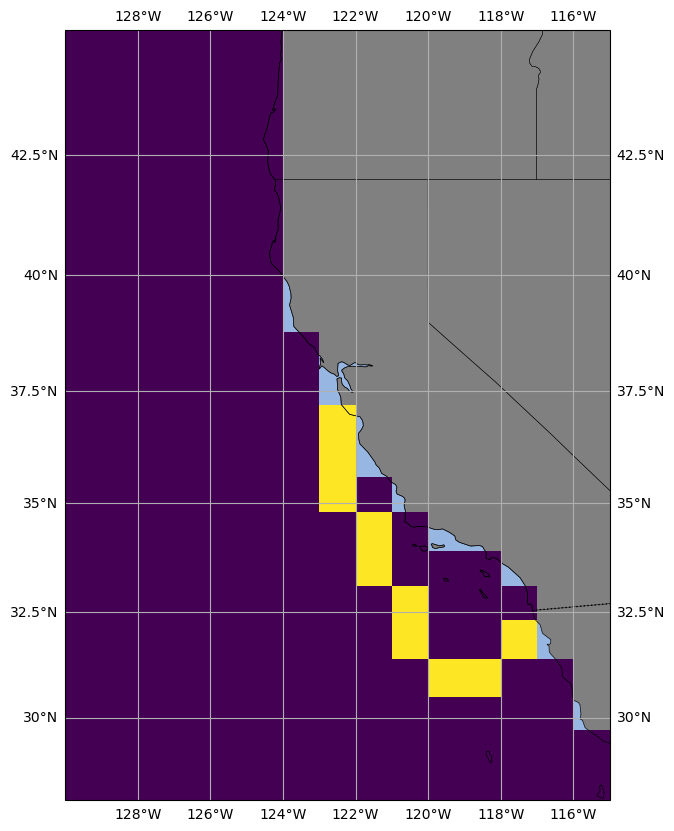

In [5]:

# Resample to focus on California coast region
tmpC = np.copy(trxC).astype('>f4')
tmpC[maskC[0,:,:,:]==0]=np.nan

lon_centers, lat_centers,\
lon_edges, lat_edges,\
mean_resampled = ecco.resample_to_latlon(XC, YC, tmpC,
                                         new_grid_min_lat=25,    # Southern boundary
                                         new_grid_max_lat=50,    # Northern boundary
                                         new_grid_delta_lat=0.1,
                                         new_grid_min_lon=-140,  # Western boundary
                                         new_grid_max_lon=-110,  # Eastern boundary
                                         new_grid_delta_lon=0.1,
                                         mapping_method='nearest_neighbor')

# Create plot with Mercator projection focused on California
fig, ax = plt.subplots(1, 1, figsize=(10, 10),
                       subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=35)})

# Plot the data
curr_plot = ax.pcolormesh(lon_centers, lat_centers, mean_resampled,
                         transform=ccrs.PlateCarree(), cmap='viridis')

# Set extent to California coast region
ax.set_extent([-130, -115, 28, 45], ccrs.PlateCarree())

# Add features
ax.add_feature(cartopy.feature.LAND, facecolor='gray')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
ax.gridlines(draw_labels=True)

plt.show()

[ 5  5  5  6  6  7  7  8  9 10]
[60 61 62 63 64 65 66 67 67 66]


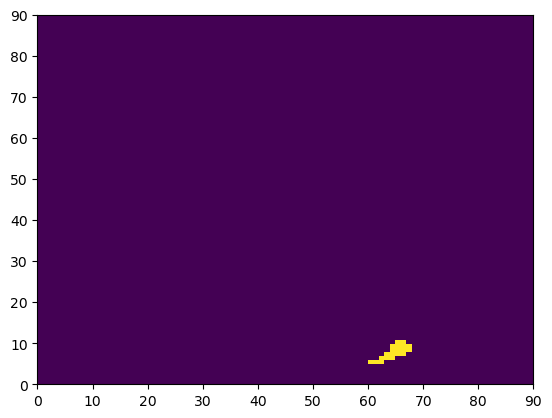

In [6]:
# check the mask point #
a = np.where(tmpC[10,:,:] == 1)
print(a[0]); print(a[1])
# print(tmpC[10,1,52])

# make the mask for CCC 
msk_ccc = tmpC[10,:,:].copy()
msk_ccc[6,62] = 1
msk_ccc[7,63:65] = 1
msk_ccc[8,64:67] = 1 
msk_ccc[9,64:67] = 1
msk_ccc[10,65] = 1

tmpC[10,:,:] = msk_ccc
tmpC[np.isnan(tmpC)] = 0
plt.pcolor(tmpC[10,:,:])


In [62]:
# Reshape drF to (50, 1, 1, 1) for broadcasting
drF_3d = drF.reshape(-1, 1, 1, 1)  # Shape: (50, 1, 1, 1)
# Compute grid cell volumes weight (m³)
mask_ccc = rA * drF_3d * hFacC * tmpC * maskC

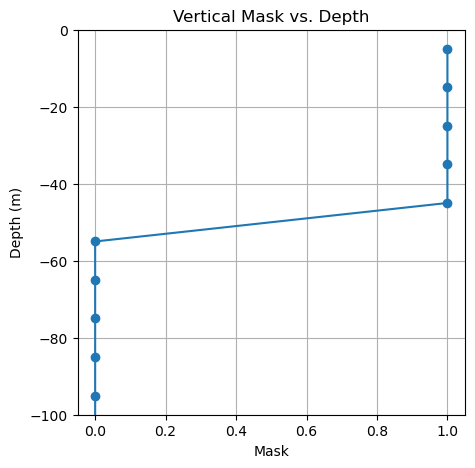

In [63]:

# Depth range in meters. Note that z1 is for the shallower layer and z2 is for the deeper layer, i.e., z1<=z2.
z1 = 0; z2 = 50
# We will use the 2d 0/1 mask for the NINO 3.4 box. First populate a 3d array with the 2d mask.
idxz = (np.abs(Zl)<z2) & (np.abs(Zl)>=z1) 

# Plot the vertical mask to check
plt.figure(figsize=(5,5))
plt.plot(idxz, Z, '-o')
plt.title('Vertical Mask vs. Depth')
plt.xlabel('Mask')
plt.ylabel('Depth (m)') 
plt.ylim(-z2*2, 0)
plt.grid()
plt.show()

# mask_ccc_surf[maskC==False] = np.nan
# plt.contourf(mask_ccc_surf[4,10,:,:]); plt.colorbar; plt.show()

Sum of mask: 1.0


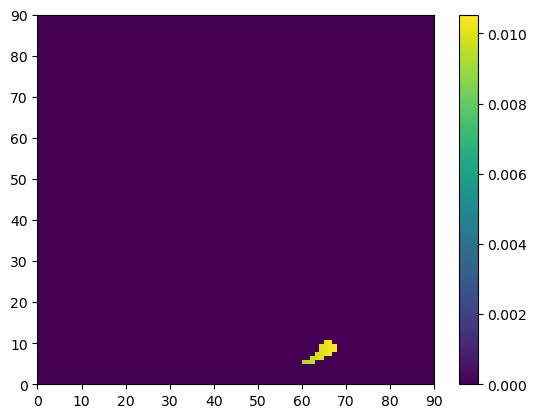

In [64]:
# mask out vertical levels outside the vertical range
mask_ccc_surf = np.copy(mask_ccc)
mask_ccc_surf[~idxz,:] = 0

# The volume weighted mask is just 
mask_ccc_surf = mask_ccc_surf / np.sum(mask_ccc_surf)

plt.pcolor(mask_ccc_surf[0,10,:,:]); plt.colorbar()
print(f'Sum of mask: {np.sum(mask_ccc_surf)}')

In [65]:
# Write out the mask to a file to be used by EMU
# First convert the 13x90x90 tile format to the compact formt 1170x90, which is the format that EMU expects for input files.
mask3d_c = ecco.llc_tiles_to_compact(mask_ccc_surf, less_output=True)

# Specify output filename
mask3d_fn = f'mask3d_ccc_surf.bin'

# Output the mask
mask3d_c.astype('>f4').tofile('/efs_ecco/ywu/'+mask3d_fn)

llc_faces_to_compact: data_compact array shape (50, 1170, 90)


In [66]:
# Write it into NetCDF files # 

# Create xarray DataArray with proper dimensions/coordinates
mask_da = xr.DataArray(
    data=mask_ccc_surf,
    dims=('k', 'tile', 'j', 'i'),
    name='mask_ccc_surf',  # Variable name in NetCDF
    attrs={
        'long_name': 'Volume-weighted mask',
        'units': '1',  # Unitless
        'description': 'Mask for California Coastal Current, 0-50m, ECCO LLC grid, volume-weighted'
    }
)

# Save to NetCDF
mask_da.to_netcdf('/efs_ecco/ywu/mask3d_ccc_surface.nc')


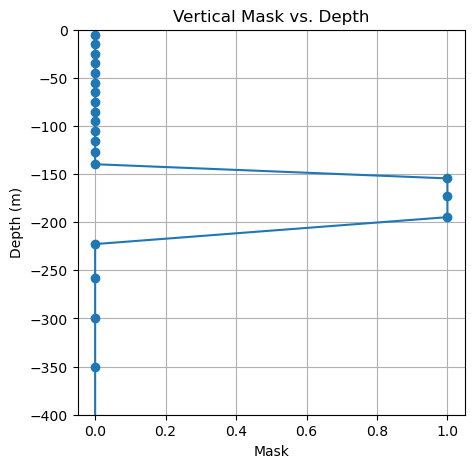

In [67]:

# Depth range in meters. Note that z1 is for the deeper layer and z2 is for the shallower layer, i.e., z1>=z2.
z1 = 140; z2 = 200
# We will use the 2d 0/1 mask for the NINO 3.4 box. First populate a 3d array with the 2d mask.
idxz = (np.abs(Zl)<z2) & (np.abs(Zl)>=z1) 

# Plot the vertical mask to check
plt.figure(figsize=(5,5))
plt.plot(idxz, Z, '-o')
plt.title('Vertical Mask vs. Depth')
plt.xlabel('Mask')
plt.ylabel('Depth (m)') 
plt.ylim(-z2*2, 0)
plt.grid()
plt.show()


Sum of mask: 0.9999999403953552


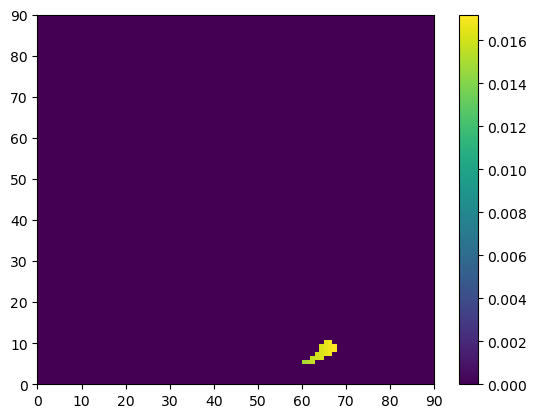

In [76]:
# mask out vertical levels outside the vertical range
mask_ccc_subsurf = np.copy(mask_ccc)
mask_ccc_subsurf[~idxz,:] = 0

# The volume weighted mask is just 
mask_ccc_subsurf = mask_ccc_subsurf / np.sum(mask_ccc_subsurf)

plt.pcolor(mask_ccc_subsurf[15,10,:,:]); plt.colorbar()
print(f'Sum of mask: {np.sum(mask_ccc_subsurf)}')

In [77]:
# Write out the mask to a file to be used by EMU
# First convert the 13x90x90 tile format to the compact formt 1170x90, which is the format that EMU expects for input files.
mask3d_c = ecco.llc_tiles_to_compact(mask_ccc_subsurf, less_output=True)

# Specify output filename
mask3d_fn = f'mask3d_ccc_subsurf.bin'

# Output the mask
mask3d_c.astype('>f4').tofile('/efs_ecco/ywu/'+mask3d_fn)

llc_faces_to_compact: data_compact array shape (50, 1170, 90)


In [71]:
# Write it into NetCDF files # 

# Create xarray DataArray with proper dimensions/coordinates
mask_da = xr.DataArray(
    data=mask_ccc_subsurf,
    dims=('k', 'tile', 'j', 'i'),
    name='mask_ccc_surf',  # Variable name in NetCDF
    attrs={
        'long_name': 'Volume-weighted mask',
        'units': '1',  # Unitless
        'description': 'Mask for California Coastal Current, 150-200m, ECCO LLC grid, volume-weighted'
    }
)

# Save to NetCDF
mask_da.to_netcdf('/efs_ecco/ywu/mask3d_ccc_subsurface.nc')


In [78]:
# Write the mask for heat budget closure, only 0 and 1 for the mask
mask_ccc_subsurf[mask_ccc_subsurf > 0] = 1
mask3d_c = ecco.llc_tiles_to_compact(mask_ccc_surf, less_output=True)

# Specify output filename
mask3d_fn = f'mask3d_ccc_subsurf_hb.bin'

# Output the mask
mask3d_c.astype('>f4').tofile('/efs_ecco/ywu/'+mask3d_fn)

llc_faces_to_compact: data_compact array shape (50, 1170, 90)


In [140]:
# Open the NetCDF file to check
ds_mask = xr.open_dataset('/efs_ecco/ywu/mask3d_ccc_surface.nc')

# Or directly load the DataArray (if saved as a single variable)
mask_loaded = xr.load_dataarray('/efs_ecco/ywu/mask3d_ccc_surface.nc')

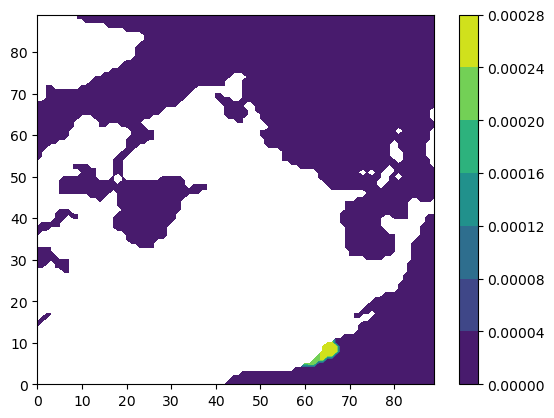

In [161]:
plt.contourf(mask_loaded[0,10,:,:]); plt.colorbar()